## Brief description of the data set and a summary of its attributes

The dataset contains the passenger information of the historical Titanic distaster, and it can be downloaded from https://www.kaggle.com/c/titanic/overview. The objective is to predict whether a passenger surivived the disaster based on various attributes given. Below is the attributes and their descriptions taken from Kaggle.

| Variable | Description | Values |
| -------- | ----------- | ------ |
| Survival | Survival | 0 = No, 1 = Yes |
| Pclass | Tickect class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Sex | Sex | |
| Age | Age in years| |
| SibSp | # of siblings / spouses aboard the Titanic | |
| Parch | # of parents / children aboard the Titanic | |
| Ticket | Ticket number | |
| Fare | Passenger fare | |
| Cabin | Cabin number | |
|Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

## Initial plan for data exploration

We will first have a peek at the data, drop certain columns and provide reasons for dropping them.

In [1]:
%pylab inline
%config InlineBachend.figure_formats = ['retina']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

os.chdir('./data')
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('titanic_train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
data.isnull().sum().sort_values()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Age            177
Cabin          687
dtype: int64

The attribute _Cabin_ has too many missing values and should be dropped.

In [6]:
print(len(data.PassengerId.unique()))
print(len(data.Name.unique()))
print(len(data.Ticket.unique()))

891
891
681


The attribute _PassengerId_, _Name_, _Ticket_ have too many unique values and should be dropped.

In [7]:
data_copy = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

## Data cleaning and feature engineering

### Impute missing values

In [8]:
values = {'Age': data_copy.Age.median(), 'Embarked': data_copy.Embarked.mode()[0]}
data_copy.fillna(value=values, inplace=True)

### Plotting the columns

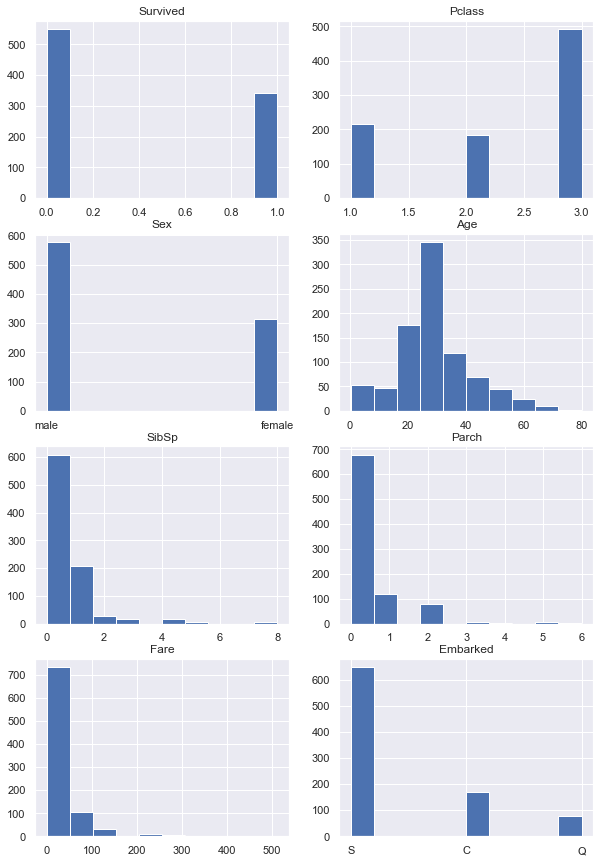

In [9]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
for i, column in enumerate(data_copy.columns):
    axes[i // 2, i % 2].hist(data_copy[column])
    axes[i // 2, i % 2].set(title=column)

As we can see, certain attributes are skewed, and we can apply log transformations to them to reduce the skew.

### Log transforming skew variables

In [10]:
X = data_copy.drop('Survived', axis=1)
y = data_copy['Survived']

num_cols = X.select_dtypes('number').columns

skew_limit = 0.75
skew_vals = X[num_cols].skew()
skew_cols = skew_vals[abs(skew_vals) > skew_limit].sort_values(ascending=False)
skew_cols.to_frame().rename(columns={0: 'Skew'})

,Skew
Fare,4.787317
SibSp,3.695352
Parch,2.749117


The skews of Fare before and after np.log1p are  4.787316519674893 and  0.3949280095189306 respectively.


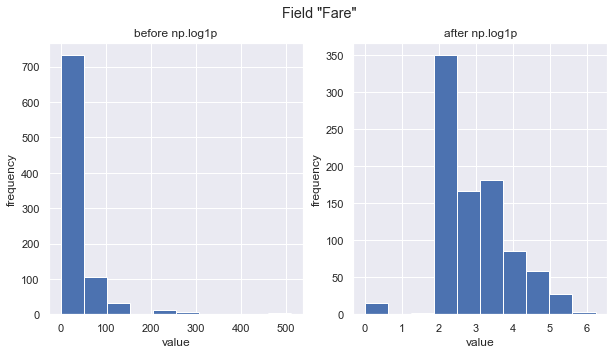

In [11]:
field = 'Fare'

fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

data_copy[field].hist(ax=ax_before)

data_copy[field].apply(np.log1p).hist(ax=ax_after)

ax_before.set(title='before np.log1p', xlabel='value', ylabel='frequency')
ax_after.set(title='after np.log1p', xlabel='value', ylabel='frequency')
fig.suptitle('Field "{}"'.format(field))

print('The skews of {field} before and after np.log1p are {before: } and {after: } respectively.'
      .format(field=field, before=data_copy[field].skew(), after=data_copy[field].apply(np.log1p).skew()))

In [12]:
for col in skew_cols.index.values:
    data_copy[col] = data_copy[col].apply(np.log1p)

### One-hot encoding categorical variables

In [13]:
one_hot_encode_cols = data_copy.dtypes[data_copy.dtypes == object]
one_hot_encode_cols = one_hot_encode_cols.index.tolist()

data_copy = pd.get_dummies(data_copy, columns=one_hot_encode_cols)
data_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.000000,0.000000,1.000000,1.000000
Pclass,891.0,2.308642,0.836071,1.00,2.000000,3.000000,3.000000,3.000000
Age,891.0,29.361582,13.019697,0.42,22.000000,28.000000,35.000000,80.000000
SibSp,891.0,0.281839,0.462838,0.00,0.000000,0.000000,0.693147,2.197225
Parch,891.0,0.217682,0.411680,0.00,0.000000,0.000000,0.000000,1.945910
Fare,891.0,2.962246,0.969048,0.00,2.187218,2.737881,3.465736,6.240917
Sex_female,891.0,0.352413,0.477990,0.00,0.000000,0.000000,1.000000,1.000000
Sex_male,891.0,0.647587,0.477990,0.00,0.000000,1.000000,1.000000,1.000000
Embarked_C,891.0,0.188552,0.391372,0.00,0.000000,0.000000,0.000000,1.000000
Embarked_Q,891.0,0.086420,0.281141,0.00,0.000000,0.000000,0.000000,1.000000


Lastly, we pair plot the attributes to visually inspect what might affect the survival rate before we work on numbers in the section **Key findings and insights**.

### Pair-plotting feature variables split by Survived

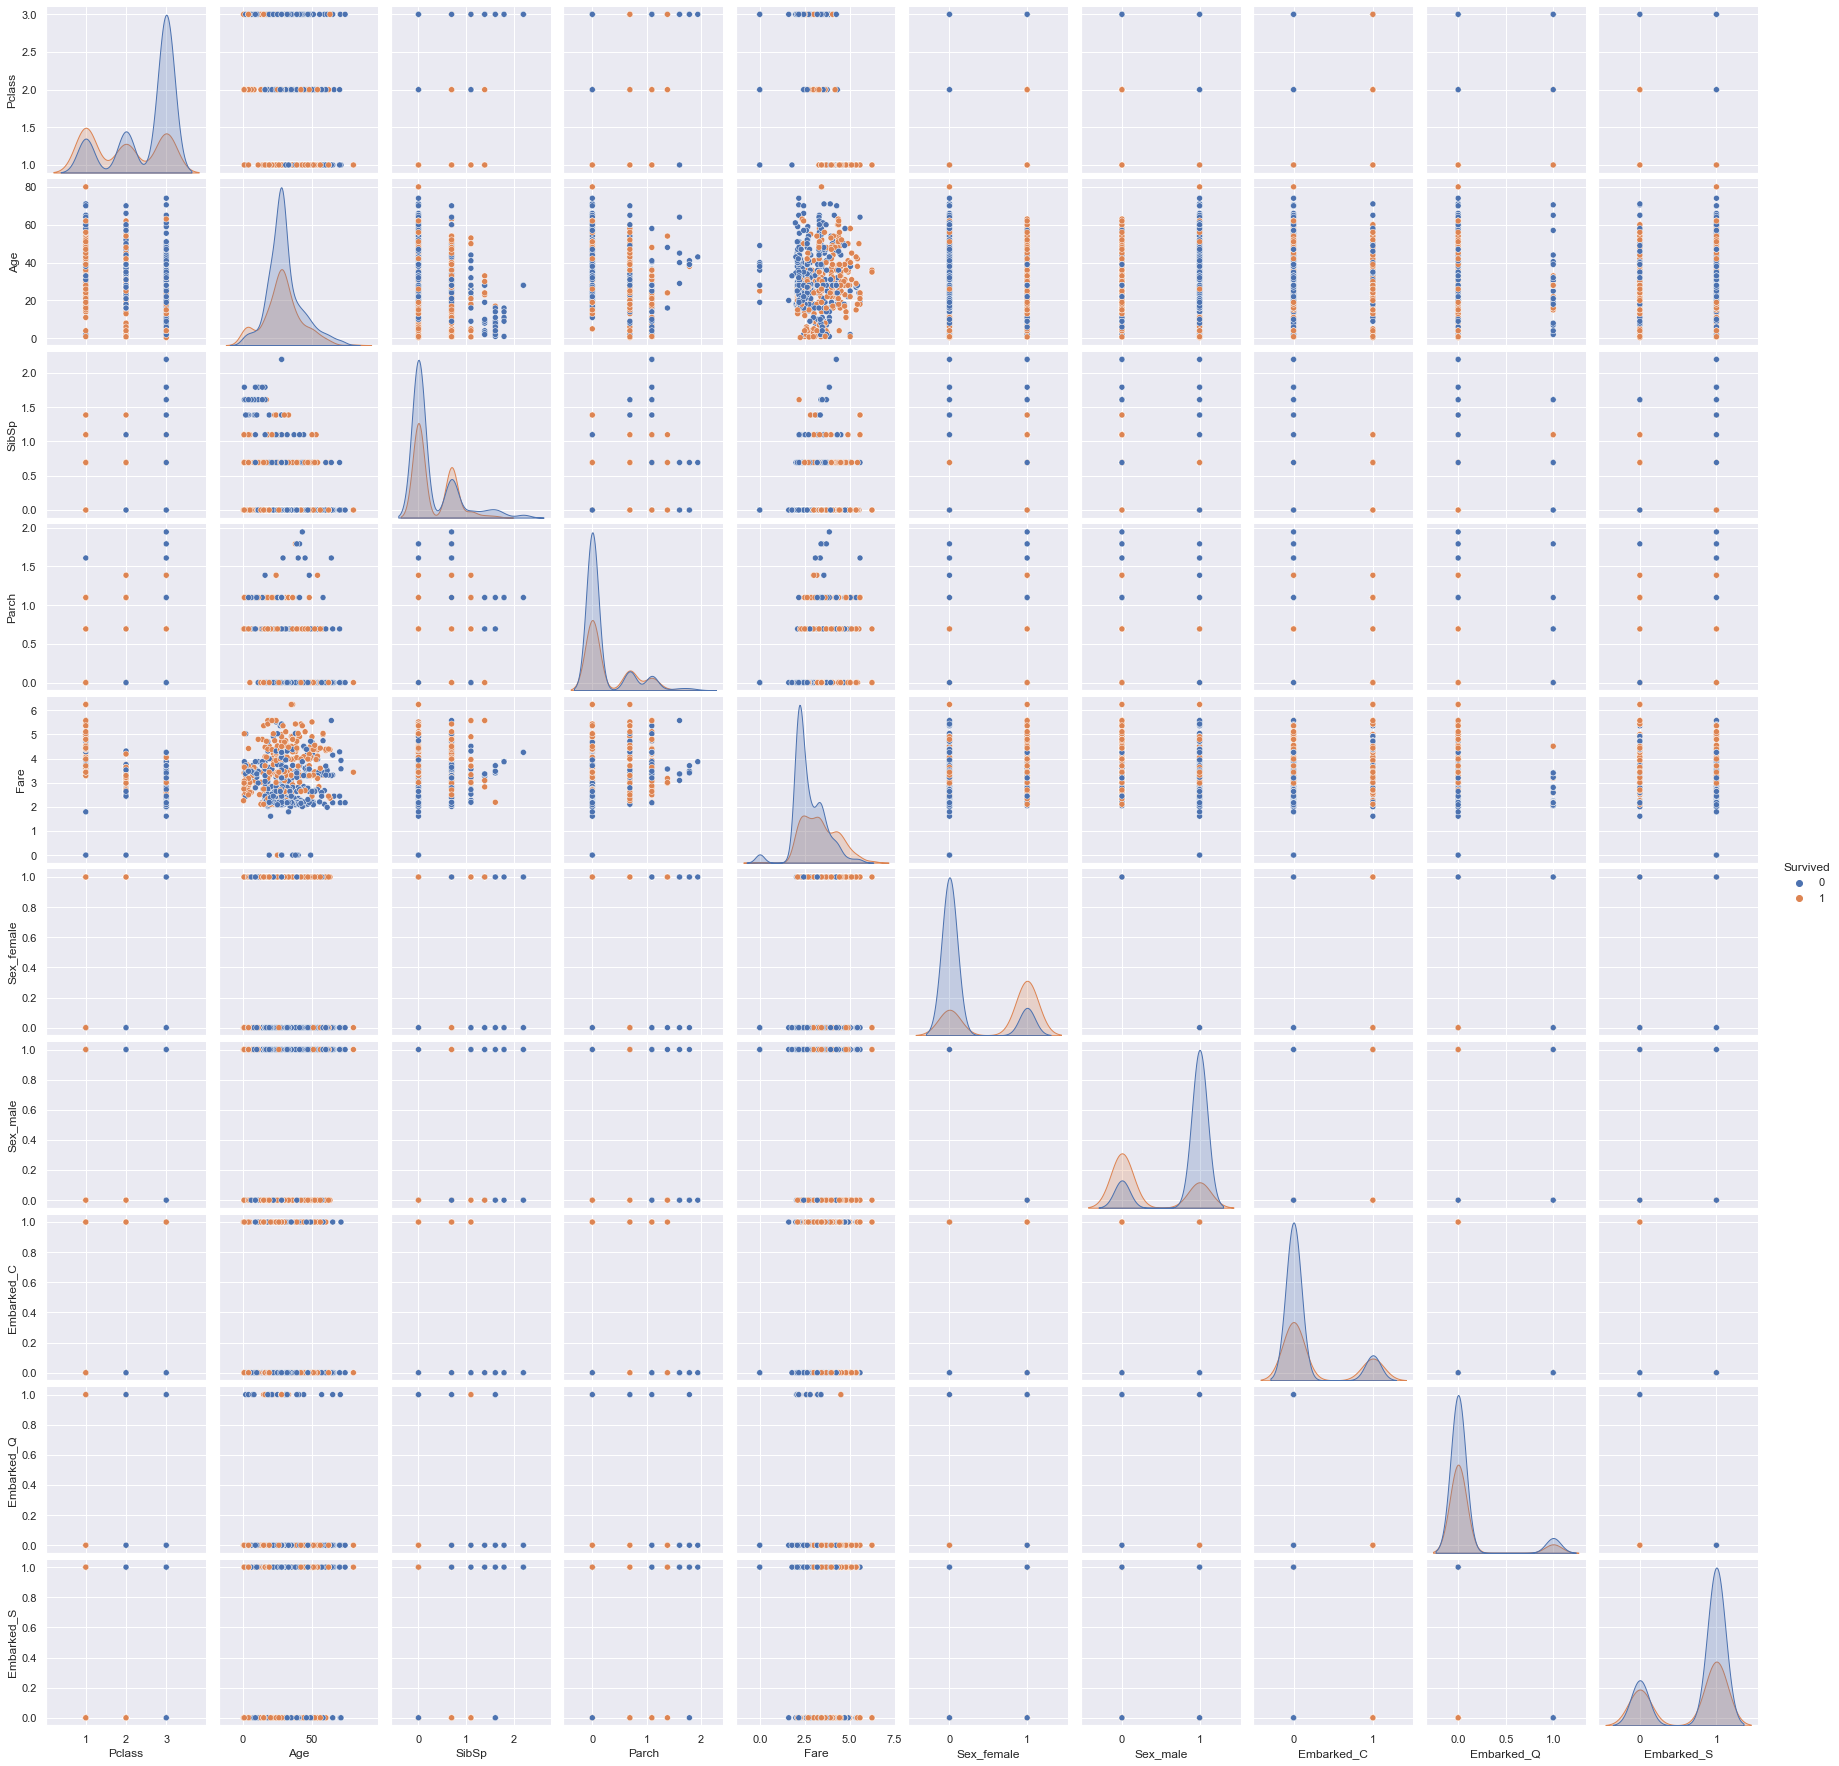

In [14]:
sns.pairplot(data_copy, hue='Survived')

## Key findings and insights

In [15]:
female = data[data.Sex == 'female']['Survived']
male = data[data.Sex == 'male']['Survived']

prob_female = sum(female) / len(female)
prob_male = sum(male) / len(male)

print(str(round(prob_female * 100, 1)) + '% of females survived.')
print(str(round(prob_male * 100, 1)) + '% of males survived.')

74.2% of females survived.
18.9% of males survived.


As we can see, the category Sex influences the survival rate significantly; being a female is more likely to survive, while being a male is less likely to survive. This insight was already pointed out in the Kaggle platform where I found the dataset, and we will elaborate more in the section **Hypotheis testing**.

In [16]:
high_fare = data[data.Fare > data.Fare.quantile(0.75)]['Survived']

prob_high_fare = sum(high_fare) / len(high_fare)

print(str(round(prob_high_fare * 100, 1)) + '% of high-fare passengers survived.')

58.1% of high-fare passengers survived.


As we can see, the category Fare also has some effect on the survival rate; the top 25 percentile
has a higher survival rate. We will elaborate more in the section **Hypothesis testing**. 

In [17]:
young_age = data[data.Age < data.Age.quantile(0.1)]['Survived']

prob_young_age = sum(young_age) / len(young_age)

print(str(round(prob_young_age * 100, 1)) + '% of young passengers (younger than {:n} years old) survived.'
     .format(data.Age.quantile(0.1)))

59.2% of young passengers (younger than 14 years old) survived.


As we can see, the category Age also has some effect on the survival rate; the lower 10 percentile are more likely to survive, and we will elaborate more in the section **Hypothesis testing**.

## Hypothesis testing

**Null hypothesis 1:** Being a female does not have any effect on Surivived; the survival rate is 0.5.

But even under this hypothesis, it could still be that 74.2% of females survived. So is it by random chance?

**Alternative 1:** Being a female increases the survival rate to above 0.5.

The thing we are measuring from the data, or **test statistic**, is the number of females that survived.

Before we check, we decide what cutoff probability would convince us that being a female increases the survival rate to above 0.5. The choice of 5% is common, and if we see data as extreme as less than 5% of the time, we will say that seems too unlikely and conclude that we don't think the null hypothesis is true.

In [18]:
from scipy.stats import binom

female = data[data.Sex == 'female']['Survived']

prob = 1 - binom.cdf(sum(female), len(female), 0.5)

print(str(prob * 100) + '%')

1.1102230246251565e-14%


The probability of having the historical percentage of females that survived, assuming the 0.5 survival rate, is extremely low. In particular, it is lower than 5%, so we can reject the null hypothesis and conclude that being a female increases the survival rate to above 0.5.

---
**Null hypothesis 2:** Having a higher fare (higher than median) does not have any effect on Survived; the survival rate is 0.5.

But even under this hypothesis, it could still be that 51.8% of high-fare passengers survived. So is it by random chance?

**Alternative 2:** Having a higher fare increases the survival rate to above 0.5.

The thing we are measuring from the data, or **test statistic**, is the number of high-fare passengers that survived.

Before we check, we decide what cutoff probability would convince us that being a female increases the survival rate to above 0.5. The choice of 5% is common, and if we see data as extreme as less than 5% of the time, we will say that seems too unlikely and conclude that we don't think the null hypothesis is true.

In [19]:
high_fare = data[data.Fare > data.Fare.quantile(0.75)]['Survived']

prob = 1 - binom.cdf(sum(high_fare), len(high_fare), 0.5)

print(str(round(prob * 100, 1)) + '%')

0.6%


The probability of having the historical percentage of high-fare passengers that survived, assuming the 0.5 survival rate, is 0.6%, which is lower than 5%, so we can reject the null hypothesis and conclude that having a higher fare increases the survival rate to above 0.5.

---

**Null hypothesis 3:** Being a kid (in the lower 10 percentile of the category Age) does not have any effect on Survived; the survival rate is 0.5.

But even under this hypothesis, it could still be that 59.2% of young passengers survived. So is it by random chance?

**Alternative 3:** Being a kid increases the survival rate to above 0.5.

The thing we are measuring from the data, or **test statistic**, is the number of high-fare passengers that survived.

Before we check, we decide what cutoff probability would convince us that being a female increases the survival rate to above 0.5. The choice of 5% is common, and if we see data as extreme as less than 5% of the time, we will say that seems too unlikely and conclude that we don't think the null hypothesis is true.

In [20]:
young_age = data[data.Age < data.Age.quantile(0.1)]['Survived']

prob = 1 - binom.cdf(sum(young_age), len(young_age), 0.5)

print(str(round(prob * 100, 1)) + '%')

4.8%


The probability of having the historic percentage of young passengers that survived, assuming the 0.5 survival rate, is 4.8%, which is lower than 5%, so we can reject the null hypothesis and conclude that being a kid increases the survival rate to above 0.5.

## Suggestions for next steps in analyzing the data

In the next steps, we could further explore if there are feature interactions that help to predict whether a passenger survived or not (I tried on the Kaggle competition). I have tried interactions between Fare and Age, and it doesn't seem to improve the predictions. We could also try to group features by another category, e.g. group Fare by Sex, but it doesn't seem to improve predictions either. If you happen to participate in the Kaggle competition and have found some interesting interactions / fancy features, I would be glad to learn that.

## Summary

We have applied the data cleaning (impute missing data) and feature engineering (log transforming data and one-hot encoding categorical data) on the Titanic dataset, and have gained some insights on the factors that influence the survival rate of a passenger. We then further confirmed these insights rigirously using hypothesis testing. This is an intersting dataset, and I believe there is more to explore (interactions / fancy features).